<a href="https://colab.research.google.com/github/seyeonjungGit/Project2_machine_learning/blob/main/(2)_%EB%AA%A8%EB%8D%B8%EC%84%A0%EC%A0%95_Section2_Project_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Preset

### 주제 : 한 사람이 연간 50K(= 50,000달러)이상을 버는가?
(k = 1000)

- 데이터셋 출처 : https://www.kaggle.com/lodetomasi1995/income-classification
- 설명 : https://sites.google.com/site/complexdataminingproject/


### Task : 이진분류문제
- 5만달러 이상 positive(1),  5만달러 이하  : negative(0)
- 5만달러 = 약 5820만7217원

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install -U matplotlib

# !pip install -U pandas-profiling

In [ ]:
!pip install catboost

In [ ]:
# !pip uninstall matplotlib
# !pip install matplotlib==3.0.2

#2.Import libraries

In [1]:
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np 

# 전처리
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 모델
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# import lightgbm as lgb
import xgboost
import shap


import eli5
from eli5.sklearn import PermutationImportance


# 평가
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # 평가지표 5개
from sklearn.metrics import roc_curve

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot


import warnings
warnings.simplefilter(action='ignore', category=Warning)  # 경고 억제

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#3.Read the dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/코드스테이츠 포폴관련/income_evaluation.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
### 컬럼명 변경
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'] 

for i in df.columns[df.dtypes == 'object']:     # 데이터 프레임 중 문자타입 변수만 선별
    df[i]= df[i].str.lstrip()                    # 데이터의 문자형 변수들마다 문자 왼쪽 띄워쓰기 제거


# 타겟컬럼 설정
target = 'income'
df[target].value_counts()

# 중복값 제거
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

24
0


In [4]:
# replace '?' values in variable with `NaN`

df.replace('?', np.NaN, inplace=True)

In [5]:
### 중복되는 피쳐의 제거, 타겟값 숫자로 변경
df = df.drop(columns = ['education-num'])
df[target] = np.where(df[target] == '<=50K', 0, 1)  # 50k보다 많이소득 1, 적은 소득 0

# 수치형 데이터 범주화 : Binning(numerical 이지만, continuous 해서 구간별로 나누어 사용 할 수 있는 경우. : 바이닝 사용. 구간에 따라 변수를 새롭게 디자인한다.)
df['age_cut']=pd.cut(df['age'], bins=[0,19,29,39,49,59,69,79,89,99] , labels=['10s','20s','30s','40s','50s','60s','70s','80s','90s'])
df = df.drop(columns=['age']) 

# high-cardinarlity 처리
df.loc[(df["native-country"] != 'United-States'),'native-country']='Other'


# 카테고리형 데이터의 유형변화 : catboost 내부 encoding시에 category형 데이터를 못받는다. (object만 받을 수 있음)
df['age_cut']= df['age_cut'].astype('object')

#4.train,val, test데이터셋 나누기
- 모델선택 후 일반화된 모델 성능을 위해 교차검증 방식 선택
- 모델선택 전 효율적인 훈련 및 평가시간 전략을 위해 train과 validation으로 split

In [6]:
### train, test
train_cross, test = train_test_split(df,
                                train_size=0.80,
                                test_size=0.20,
                                stratify=df[target],  # target의 비율을 유지하도록 train과 test셋 분리
                                random_state=3)

train_cross.shape, test.shape
# 교차검증을 위해 train_cross 생성

((26029, 14), (6508, 14))

In [7]:
### 검증 데이터 만들기
train, val = train_test_split(train_cross, train_size=0.80, test_size=0.20,
                             stratify=train_cross[target], random_state=2)

In [8]:
### target을 분리
X_train = train.drop(columns=[target])
y_train = train[target]

X_val = val.drop(columns=[target])
y_val = val[target]

X_test = test.drop(columns=[target])
y_test = test[target]

# 교차검증 위한 데이터셋
X_c_train = train_cross.drop(columns=[target])
y_c_train = train_cross[target]

#5.모델선택1) : CatBoost

In [9]:
# 인코딩을 모델 내부에서 해줄 수 있음.

# 결측치는 최빈값으로.
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_imp = imp.fit_transform(X_train)
X_val_imp = imp.fit_transform(X_val)

clf_catboost = CatBoostClassifier(random_state=2)
clf_catboost.fit(X_train_imp, y_train, cat_features=np.where(X_train.dtypes== 'object')[0].tolist(), eval_set=(X_val_imp, y_val)); 

# ValueError: Pipeline.fit does not accept the cat_features parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

Learning rate set to 0.067079
0:	learn: 0.6346454	test: 0.6336837	best: 0.6336837 (0)	total: 149ms	remaining: 2m 29s
1:	learn: 0.5914991	test: 0.5895254	best: 0.5895254 (1)	total: 247ms	remaining: 2m 3s
2:	learn: 0.5517310	test: 0.5489367	best: 0.5489367 (2)	total: 359ms	remaining: 1m 59s
3:	learn: 0.5125287	test: 0.5107908	best: 0.5107908 (3)	total: 413ms	remaining: 1m 42s
4:	learn: 0.4819616	test: 0.4810742	best: 0.4810742 (4)	total: 458ms	remaining: 1m 31s
5:	learn: 0.4527932	test: 0.4524003	best: 0.4524003 (5)	total: 501ms	remaining: 1m 23s
6:	learn: 0.4307430	test: 0.4307256	best: 0.4307256 (6)	total: 559ms	remaining: 1m 19s
7:	learn: 0.4120242	test: 0.4121677	best: 0.4121677 (7)	total: 673ms	remaining: 1m 23s
8:	learn: 0.3984684	test: 0.3992396	best: 0.3992396 (8)	total: 774ms	remaining: 1m 25s
9:	learn: 0.3852092	test: 0.3856784	best: 0.3856784 (9)	total: 838ms	remaining: 1m 22s
10:	learn: 0.3743418	test: 0.3746366	best: 0.3746366 (10)	total: 908ms	remaining: 1m 21s
11:	learn: 0

In [ ]:
X_val_imp

array([['Private', 199336, 'Assoc-voc', ..., 50, 'United-States', '20s'],
       ['Private', 33124, 'Prof-school', ..., 99, 'United-States', '30s'],
       ['Private', 163726, '5th-6th', ..., 49, 'United-States', '60s'],
       ...,
       ['Private', 201844, 'HS-grad', ..., 40, 'Other', '20s'],
       ['Private', 58985, 'Some-college', ..., 24, 'United-States',
        '50s'],
       ['Local-gov', 230754, 'Masters', ..., 40, 'United-States', '30s']],
      dtype=object)

### CatBoost 결과

In [ ]:
# 성능이 조금 향상
print('훈련 정확도: ', clf_catboost.score(X_train_imp, y_train))
print('검증 정확도', clf_catboost.score(X_val_imp, y_val))
print(classification_report(y_val, clf_catboost.predict(X_val_imp)))

y_pred_proba = clf_catboost.predict_proba(X_val_imp)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

# 거의 동일한 결과. 과적합 피할 수 있게 함.

훈련 정확도:  0.8895452144263555
검증 정확도 0.8703419131771033
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      3952
           1       0.76      0.67      0.71      1254

    accuracy                           0.87      5206
   macro avg       0.83      0.80      0.81      5206
weighted avg       0.87      0.87      0.87      5206

AUC score:  0.9269825425036644


Text(0, 0.5, 'TPR')

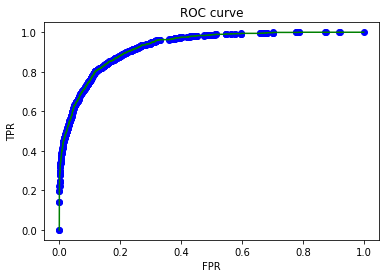

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
%matplotlib inline
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

## Permutation Importances (순열중요도)
- 관심있는 특성에만 무작위로 노이즈를 주고 예측을 하였을 때, 성능평가지표가 얼마나 감소하는지를 측정함.
- 특성값에 무작위로 노이즈를 주어(shuffle) 기존 정보를 제거, 특성이 기존에 하던 역할을 하지 못하게 하고 성능측정.

### 참고) Feature Importances (특성중요도)
- 각각 특성을 모든 트리에 대해 평균불순도감소(mean decrease impurity)를 계산한 값.

In [ ]:
clf_catboost.feature_importances_

array([ 3.86805728,  5.60187693, 10.52297873,  8.47793969,  8.79626949,
       13.67490765,  1.54796951,  1.4662643 , 18.41713894,  6.68540303,
        9.69314164,  0.85284006, 10.39521273])

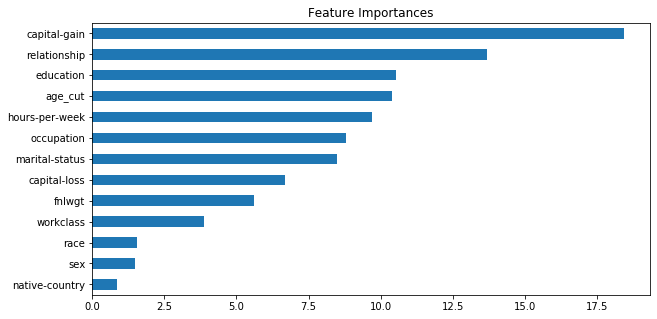

In [ ]:
importances = pd.Series(clf_catboost.feature_importances_, X_train.columns)

%matplotlib inline 

plt.figure(figsize = (10,5))
plt.title(f'Feature Importances')
importances.sort_values().plot.barh();

In [ ]:
# 특성중요도로 알아본, 중요한 특성의 순서

importances_list = importances.sort_values(ascending=False).index
importances_list

Index(['capital-gain', 'relationship', 'education', 'age_cut',
       'hours-per-week', 'occupation', 'marital-status', 'capital-loss',
       'fnlwgt', 'workclass', 'race', 'sex', 'native-country'],
      dtype='object')

In [ ]:
#컬럼별 유일값 갯수세기 
X_train.nunique()  

# 수치형 특성을 제외하고 high cardinality는 없음

workclass             8
fnlwgt            15520
education            16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        115
capital-loss         86
hours-per-week       90
native-country        2
age_cut               9
dtype: int64

### 순열중요도

In [ ]:
# SimpleImputer한 결과를 데이터프레임으로 저장
df_Xval_imp = pd.DataFrame(X_val_imp, columns = X_val.columns)
df_Xval_imp.head(1)

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,age_cut
0,Private,199336,Assoc-voc,Never-married,Craft-repair,Unmarried,White,Male,0,0,50,United-States,20s


In [ ]:
# 특성선택
feature = df_Xval_imp.columns[0]

# 특성의 값을 무작위로 섞기
X_val_permuted = df_Xval_imp.copy()
X_val_permuted[feature] = np.random.RandomState(seed=7).permutation(X_val_permuted[feature])

# 순열 중요도 값 얻기
score_permuted = clf_catboost.score(X_val_permuted, y_val)

# 원래의 검증 정확도
score_with = clf_catboost.score(X_val_imp, y_val)

In [ ]:
print(f'검증 정확도 ({feature}): {score_with}')
print(f'검증 정확도 (permuted "{feature}"): {score_permuted}')
print(f'순열 중요도: {score_with - score_permuted}')

검증 정확도 (workclass): 0.8703419131771033
검증 정확도 (permuted "workclass"): 0.8670764502497119
순열 중요도: 0.0032654629273913827


위의 과정을 모든 특성에 대해 실행

In [ ]:
# 순열중요도 데이터프레임 만드는 함수
def permuter(clf_catboost, X_val_imp):
    # SimpleImputer한 결과를 데이터프레임으로 저장
    df_Xval_imp = pd.DataFrame(X_val_imp, columns = X_val.columns)  

    # return할 순열중요도 df
    Weight_Feature = pd.DataFrame(columns = ['Weight','Feature']) 

    # 특성선택
    for i in range(len(df_Xval_imp.columns)):
        feature = df_Xval_imp.columns[i]

        # 특성의 값을 무작위로 섞기
        X_val_permuted = df_Xval_imp.copy()
        X_val_permuted[feature] = np.random.RandomState(seed=7).permutation(X_val_permuted[feature])   # 랜덤시드 반복 생략

        # 한 개의 특성을 제외한 검증정확도
        score_permuted = clf_catboost.score(X_val_permuted, y_val)

        # 원래의 검증 정확도
        score_with = clf_catboost.score(X_val_imp, y_val)

        # 순열 중요도 얻기(얼마나 중요한가)
        score_gap = score_with - score_permuted

        # 특성별 score를 데이터프레임에 추가         
        Weight_Feature.loc[len(Weight_Feature)] = [score_gap,feature]
    
    # 순서정렬
    Weight_Feature = Weight_Feature.sort_values(by=['Weight'], ascending= False).reset_index(drop=True)

    return Weight_Feature

In [ ]:
Permutation_Importance = permuter(clf_catboost, X_val_imp)
Permutation_Importance

,Weight,Feature
0,0.051479,capital-gain
1,0.025932,education
2,0.016711,occupation
3,0.016135,age_cut
4,0.015751,marital-status
5,0.014406,relationship
6,0.013254,capital-loss
7,0.003265,workclass
8,0.001921,hours-per-week
9,0.000960,fnlwgt


In [ ]:
permutation_list = Permutation_Importance['Feature'].tolist()

In [ ]:
importances_list = pd.DataFrame(importances_list)
permutation_list = pd.DataFrame(permutation_list)
df_list = pd.concat([importances_list,permutation_list], axis=1)
df_list.columns = ['특성중요도', '순열중요도']
df_list

# 1) 자본소득, 2) 교육수준, 3) 직업, 4) 나이, 5) 결혼상태 순이라는걸 알수있음.

# 그런데 이게 음의 상관관계인지 양의 상관관계인지는 아직까지 알수없다. 

,특성중요도,순열중요도
0,capital-gain,capital-gain
1,relationship,education
2,education,occupation
3,age_cut,age_cut
4,hours-per-week,marital-status
5,occupation,relationship
6,marital-status,capital-loss
7,capital-loss,workclass
8,fnlwgt,hours-per-week
9,workclass,fnlwgt


### Feature selection(특성 선택)
- 중요도가 -인 특성을 제외해도 성능은 거의 영향이 없고, 모델학습 속도는 개선됨.

In [ ]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (20823, 13) (5206, 13)


In [ ]:
# 특성 선택할 최저 score를 다르게 지정해서 모델 성능 파악
minimum_importance = 0.0001
mask = Permutation_Importance['Weight'] > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [ ]:
X_train_selected.shape,X_val_selected.shape, y_train.shape, y_val.shape

((20823, 11), (5206, 11), (20823,), (5206,))

In [ ]:
# 모델 재정의

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_imp = imp.fit_transform(X_train_selected)
X_val_imp = imp.fit_transform(X_val_selected)

clf_catboost = CatBoostClassifier(random_state=2)
clf_catboost.fit(X_train_imp, y_train, cat_features=np.where(X_train_selected.dtypes== 'object')[0].tolist(), eval_set=(X_val_imp, y_val)); 

Learning rate set to 0.067079
0:	learn: 0.6344192	test: 0.6331264	best: 0.6331264 (0)	total: 93.7ms	remaining: 1m 33s
1:	learn: 0.5892102	test: 0.5870882	best: 0.5870882 (1)	total: 167ms	remaining: 1m 23s
2:	learn: 0.5479885	test: 0.5447833	best: 0.5447833 (2)	total: 225ms	remaining: 1m 14s
3:	learn: 0.5099892	test: 0.5065699	best: 0.5065699 (3)	total: 298ms	remaining: 1m 14s
4:	learn: 0.4793883	test: 0.4757853	best: 0.4757853 (4)	total: 358ms	remaining: 1m 11s
5:	learn: 0.4542691	test: 0.4504572	best: 0.4504572 (5)	total: 419ms	remaining: 1m 9s
6:	learn: 0.4337583	test: 0.4308652	best: 0.4308652 (6)	total: 501ms	remaining: 1m 11s
7:	learn: 0.4158904	test: 0.4141273	best: 0.4141273 (7)	total: 585ms	remaining: 1m 12s
8:	learn: 0.4020552	test: 0.4001828	best: 0.4001828 (8)	total: 651ms	remaining: 1m 11s
9:	learn: 0.3898720	test: 0.3887481	best: 0.3887481 (9)	total: 714ms	remaining: 1m 10s
10:	learn: 0.3791277	test: 0.3784953	best: 0.3784953 (10)	total: 775ms	remaining: 1m 9s
11:	learn: 0

#### 특성선택 결과

In [ ]:
# train 학습, 검증셋 정확도 0.001
# 피쳐 수 줄임으로써 모델학습 속도의 개선이 있겠지만, 원래 피쳐 수가 많지 않고 모델 성능도 약간 떨어지기 때문에 특성선택 하지 않기로 함.

print('훈련 정확도: ', clf_catboost.score(X_train_imp, y_train))
print('검증 정확도', clf_catboost.score(X_val_imp, y_val))

print(classification_report(y_val, clf_catboost.predict(X_val_imp)))

y_pred_proba = clf_catboost.predict_proba(X_val_imp)[:, 1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, clf_catboost.predict(X_val_imp)))

훈련 정확도:  0.8845987609854488
검증 정확도 0.864963503649635
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      3952
           1       0.75      0.66      0.70      1254

    accuracy                           0.86      5206
   macro avg       0.82      0.80      0.81      5206
weighted avg       0.86      0.86      0.86      5206

AUC score:  0.9216245867475092
오차행렬 :  [[3671  281]
 [ 422  832]]


#5.모델선택2) : LightGBM

In [ ]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('lgbm', LGBMClassifier(random_state=2,
                         n_jobs=-1,
                        ))
])

pipe.fit(X_train, y_train);

### LightGBM 결과

In [ ]:
# 가중치 x
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))
print(classification_report(y_val, pipe.predict(X_val)))

y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, pipe.predict(X_val)))

# 거의 동일한 결과. 과적합 피할 수 있게 함.

훈련 정확도:  0.8879604283724728
검증 정확도 0.8734152900499423
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.78      0.66      0.71      1254

    accuracy                           0.87      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.87      0.87      5206

AUC score:  0.9245120069219792
오차행렬 :  [[3723  229]
 [ 430  824]]


Text(0, 0.5, 'TPR')

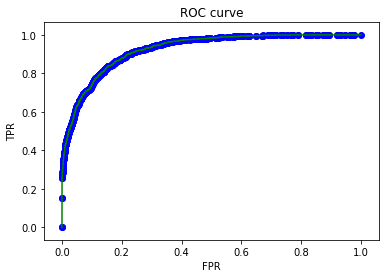

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
%matplotlib inline
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

## Permutation Importances (순열중요도)
- 관심있는 특성에만 무작위로 노이즈를 주고 예측을 하였을 때, 성능평가지표가 얼마나 감소하는지를 측정함.
- 특성값에 무작위로 노이즈를 주어(shuffle) 기존 정보를 제거, 특성이 기존에 하던 역할을 하지 못하게 하고 성능측정.

### 참고) Feature Importances (특성중요도)
- 각각 특성을 모든 트리에 대해 평균불순도감소(mean decrease impurity)를 계산한 값.

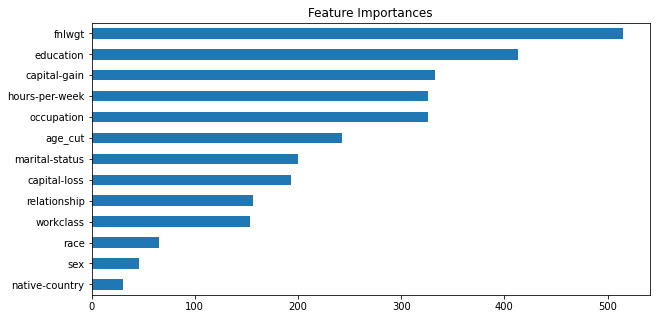

In [ ]:
lgbm = pipe.named_steps['lgbm']
importances = pd.Series(lgbm.feature_importances_, X_train.columns)

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))
plt.title(f'Feature Importances')
importances.sort_values().plot.barh();

In [ ]:
# 특성중요도로 알아본, 중요한 특성의 순서

importances_list = importances.sort_values(ascending=False).index
importances_list

Index(['fnlwgt', 'education', 'capital-gain', 'occupation', 'hours-per-week',
       'age_cut', 'marital-status', 'capital-loss', 'relationship',
       'workclass', 'race', 'sex', 'native-country'],
      dtype='object')

In [ ]:
#컬럼별 유일값 갯수세기 
X_train.nunique()  

# --> fnlwgt는 18380개의 카테고리로 구성되어 있는데, 다른 특성과 비교하여 high-cardinarity특성이다. 
# 과적합 위험이 있는 특성임. 

workclass             9
fnlwgt            15520
education            16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        115
capital-loss         86
hours-per-week       90
native-country        2
age_cut               9
dtype: int64

### 순열중요도

In [ ]:
# 순열중요도

#permuter정의
permuter = PermutationImportance(
    pipe.named_steps['lgbm'],  #model
    scoring= 'f1_macro', #'accuracy', # 'f1_macro',
    n_iter=5,  #다른 랜덤시드 사용해서 5번 반복
    random_state=2)

X_transformed = pipe.named_steps['preprocessing'].transform(X_val)

permuter.fit(X_transformed, y_val);

In [ ]:
feature_names = X_val.columns.tolist()
permutation_list = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending = False).index
permutation_list

Index(['marital-status', 'capital-gain', 'education', 'occupation', 'age_cut',
       'capital-loss', 'hours-per-week', 'relationship', 'fnlwgt', 'workclass',
       'sex', 'native-country', 'race'],
      dtype='object')

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식
)

Weight,Feature
0.0951 ± 0.0102,marital-status
0.0760 ± 0.0017,capital-gain
0.0415 ± 0.0044,education
0.0327 ± 0.0062,occupation
0.0281 ± 0.0059,age_cut
0.0185 ± 0.0037,capital-loss
0.0151 ± 0.0027,hours-per-week
0.0103 ± 0.0016,relationship
0.0053 ± 0.0030,fnlwgt
0.0041 ± 0.0027,workclass


In [ ]:
importances_list = pd.DataFrame(importances_list)
permutation_list = pd.DataFrame(permutation_list)
df_list = pd.concat([importances_list,permutation_list], axis=1)
df_list.columns = ['특성중요도', '순열중요도']
df_list

# 고소득과 연관이 높은건 1) 자본소득, 2) 직업, 3) 학력, 4) 결혼상태, 5) 나이 순이라는걸 알수있음.
# 인종이나,  관계 와는 별 상관이 없음.


# 그런데 이게 음의 상관관계인지 양의 상관관계인지는 아직까지 알수없다. 

,특성중요도,순열중요도
0,fnlwgt,marital-status
1,education,capital-gain
2,capital-gain,education
3,occupation,occupation
4,hours-per-week,age_cut
5,age_cut,capital-loss
6,marital-status,hours-per-week
7,capital-loss,relationship
8,relationship,fnlwgt
9,workclass,workclass


### Feature selection(특성 선택)
- 중요도가 -인 특성을 제외해도 성능은 거의 영향이 없고, 모델학습 속도는 개선됨.

In [ ]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (20823, 13) (5206, 13)


In [ ]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [ ]:
X_train_selected.shape,X_val_selected.shape, y_train.shape, y_val.shape

((20823, 11), (5206, 11), (20823,), (5206,))

In [ ]:
# pipeline 다시 정의

pipe_set = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('lgbm', LGBMClassifier(random_state=2,
                         n_jobs=-1,
                        ))
])

pipe_set.fit(X_train_selected, y_train);

#### 특성선택 결과

In [ ]:
# train 학습, 검증셋 정확도
# 성능도 약간 향상되고 피쳐수도 줄임.

print('훈련 정확도: ', pipe_set.score(X_train_selected, y_train))
print('검증 정확도', pipe_set.score(X_val_selected, y_val))
print(classification_report(y_val, pipe_set.predict(X_val_selected)))

y_pred_proba = pipe_set.predict_proba(X_val_selected)[:, 1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, pipe_set.predict(X_val_selected)))

훈련 정확도:  0.8869519281563656
검증 정확도 0.8745678063772571
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.78      0.66      0.72      1254

    accuracy                           0.87      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.87      0.87      5206

AUC score:  0.9257918184078155
오차행렬 :  [[3721  231]
 [ 422  832]]


## X_train, X_val, X_test train 특성변경

In [ ]:
# 중요하지 않은 피쳐 없애기.

minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
# features = X_train.columns[mask]


X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((20823, 11), (5206, 11), (6508, 11))

In [ ]:
# 특성별 범주의 수

X_train.nunique()

workclass             9
fnlwgt            15520
education            16
marital-status        7
occupation           15
relationship          6
sex                   2
capital-gain        115
capital-loss         86
hours-per-week       90
age_cut               9
dtype: int64

언더샘플링
- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.under_sampling.CondensedNearestNeighbour.html
- https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html

#6.LightGBM 하이퍼파라미터 튜닝
- https://dailyheumsi.tistory.com/136

## 1) early stopping으로 최적 n_estimators 최적화

In [ ]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

simpleimputer = SimpleImputer()
X_train_simple  = simpleimputer.fit_transform(X_train_encoded) 
X_val_simple = simpleimputer.transform(X_val_encoded)

# cnn = CondensedNearestNeighbour(random_state=2)
# X_samp, y_samp = cnn.fit_resample(X_train_simple, y_train)
# X_samp, y_samp = cnn.fit_resample(X_val_simple, y_train)

In [ ]:
#Early Stopping 으로 과적합 피하기

model =  LGBMClassifier(random_state=2,
                         n_jobs=-1,
                        n_estimators=1000,
                        )


eval_set = [(X_train_simple, y_train), 
            (X_val_simple, y_val)]

model.fit(X_train_simple, y_train, 
          eval_set=eval_set,  # eval_set= 메트릭이 계산될 검증 세트로 사용할 (X, y) 튜플 쌍의 목록입니다. 검증 메트릭은 모델의 성능을 추적하는 데 도움이 됩니다
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[1]	training's binary_logloss: 0.510554	training's binary_error: 0.240936	valid_1's binary_logloss: 0.509938	valid_1's binary_error: 0.240876
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_logloss: 0.480019	training's binary_error: 0.240936	valid_1's binary_logloss: 0.479278	valid_1's binary_error: 0.240876
[3]	training's binary_logloss: 0.455655	training's binary_error: 0.240936	valid_1's binary_logloss: 0.454949	valid_1's binary_error: 0.240876
[4]	training's binary_logloss: 0.435415	training's binary_error: 0.182971	valid_1's binary_logloss: 0.434952	valid_1's binary_error: 0.177872
[5]	training's binary_logloss: 0.417488	training's binary_error: 0.179369	valid_1's binary_logloss: 0.417366	valid_1's binary_error: 0.176335
[6]	training's binary_logloss: 0.403334	training's binary_error: 0.177448	valid_1's binary_logloss: 0.403252	valid_1's binary_error: 0.17499
[7]	training's binary_logloss: 0.390056	training's binary_error: 0.166739	valid_1's bin

LGBMClassifier(n_estimators=1000, random_state=2)

In [ ]:
print(model.best_iteration_)
print(model.evals_result_)

82
{'training': defaultdict(<class 'list'>, {'binary_logloss': [0.5105535493803629, 0.4800187367382676, 0.4556553785347673, 0.4354148731827498, 0.417487834480056, 0.4033340364738898, 0.3900555363264675, 0.37888803268035853, 0.36941803518662925, 0.3612657768639944, 0.35393901957304325, 0.3474514770336104, 0.3409372951695229, 0.3357711718995485, 0.3307150257405817, 0.3267933949081176, 0.3227819994010274, 0.3185762420899342, 0.315502903748813, 0.3127059800552194, 0.31024169114436895, 0.3076968606886719, 0.3050534790368119, 0.3028748949467809, 0.30062936501088805, 0.298895017178884, 0.29712309543337295, 0.295123695889541, 0.2936735333621112, 0.2921363470225816, 0.29093773433192655, 0.2897290028250686, 0.2879718475073701, 0.2869803426769332, 0.2857964897567605, 0.28480837203540327, 0.283823948227156, 0.2825662252554477, 0.28134895803058174, 0.2803996327141471, 0.2795537509648382, 0.2787039686051431, 0.2779901437643979, 0.276906251122071, 0.2761785530904948, 0.27534903460989335, 0.2744846265

In [ ]:
model.evals_result_.keys()

dict_keys(['training', 'valid_1'])

In [ ]:
model.evals_result_['training'].keys()

dict_keys(['binary_error', 'binary_logloss'])

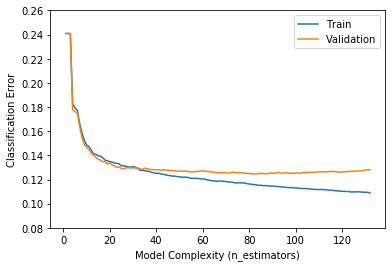

In [ ]:
results = model.evals_result_
train_error = results['training']['binary_error']
val_error = results['valid_1']['binary_error']
%matplotlib inline 
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.08, 0.26)) # Zoom in
plt.legend();

### n_estimators 튜닝 결과

In [ ]:
print('훈련 정확도: ', model.score(X_train_simple, y_train))
print('검증 정확도', model.score(X_val_simple, y_val))

print(classification_report(y_val, model.predict(X_val_simple)))

y_pred_proba = model.predict_proba(X_val_simple)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, model.predict(X_val_simple)))

# 거의 동일한 결과. 과적합 피할 수 있게 함.

훈련 정확도:  0.8842145704269317
검증 정확도 0.8753361505954668
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.79      0.66      0.72      1254

    accuracy                           0.88      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.88      0.87      5206

AUC score:  0.9255686459201001
오차행렬 :  [[3726  226]
 [ 423  831]]


## 2) Randomized Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

model_tuning =  LGBMClassifier(random_state=2,
                         n_jobs=-1,
                        n_estimators=82,
                        bagging_freq = 1
                        )


dists = {  
        'num_leaves' : [31, 34],     # default 31
        'bagging_fraction' : [1, 0.9],   # default 1
        'feature_fraction' : [1, 0.9],   # default 1
        'learning_rate': [0.1, 0.08, 0.05],   # default 0.1
        # 'boosting':  ['gbdt', 'dart','goss'],       # default gradient boosting tree
        # 'Maximum Depth' :   # default -1가 가장 성능이 좋다고 알려져있음

}     

clf = RandomizedSearchCV(
    model_tuning, 
    param_distributions=dists, 
    random_state=2,
    n_iter=50, 
    cv=3, 
    scoring='accuracy',   
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train_simple, y_train);

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('error: ', clf.best_score_)

최적 하이퍼파라미터:  {'num_leaves': 34, 'learning_rate': 0.1, 'feature_fraction': 1, 'bagging_fraction': 1}
error:  0.8711520914373528


In [ ]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
model_best = clf.best_estimator_

### 랜덤CV결과

In [ ]:
print('검증 정확도',model_best.score(X_val_simple, y_val))

print(classification_report(y_val, model_best.predict(X_val_simple)))

y_pred_proba = model_best.predict_proba(X_val_simple)[:, 1]

print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, model_best.predict(X_val_simple)))

검증 정확도 0.8718786016135228
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.78      0.66      0.71      1254

    accuracy                           0.87      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.87      0.87      5206

AUC score:  0.9250211065481149
오차행렬 :  [[3712  240]
 [ 427  827]]


In [ ]:
model_best

### --> 데이터 갯수나 시간적 상황 등 고려했을 때, 좀 더 효율적인 early stopping 튜닝으로 완료

#7.최종모델 test데이터에 적용

In [ ]:
X_test_encoded = encoder.transform(X_test)
X_test_simple = simpleimputer.transform(X_test_encoded)

In [ ]:
print('검증 정확도', model.score(X_test_simple, y_test))

print(classification_report(y_test, model.predict(X_test_simple)))

# 거의 동일한 결과. 과적합 피할 수 있게 함.

y_pred_proba = model.predict_proba(X_test_simple)[:, -1]
print('AUC score: ', roc_auc_score(y_test, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_test, model.predict(X_test_simple)))

검증 정확도 0.8716963736939152
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4940
           1       0.78      0.65      0.71      1568

    accuracy                           0.87      6508
   macro avg       0.84      0.79      0.81      6508
weighted avg       0.87      0.87      0.87      6508

AUC score:  0.9202357499173758
오차행렬 :  [[4660  280]
 [ 555 1013]]
